In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import networkx as nx
from IPython.display import clear_output

sns.set_style(style="whitegrid")

In [2]:
def set_seed(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    if torch.backends.mps.is_available():
        torch.mps.manual_seed(seed)

seed = 1337
set_seed(seed)

In [3]:
import os
import sys

notebook_dir = os.getcwd()

root_dir = os.path.abspath(os.path.join(notebook_dir, "../../"))
sys.path.append(root_dir)

In [4]:
from dotenv import load_dotenv

load_dotenv()

from coral import DataSourceFactory
from core.models.datasource_type import DataSourceType
from core.models.protocol_type import ProtocolType
from service import EnvironmentSecretService

In [1856]:
DEFAULT_DATASOUCE = DataSourceType.BYBIT
DEFAULT_SYMBOLS = ["AVAXUSDT"]
SLEEP_INTERVAL = 1
DOM = 10
EPS = np.finfo(float).eps

In [1857]:
datasource = DataSourceFactory(EnvironmentSecretService())
datasource.register_rest_exchange(DEFAULT_DATASOUCE)

ds = datasource.create(DEFAULT_DATASOUCE, ProtocolType.REST)

In [1858]:
symbols = ds.fetch_future_symbols()
symbol = [symbol for symbol in symbols if symbol.name in DEFAULT_SYMBOLS]

In [1859]:
def plot_order_book(bids, asks, highlight_best=True):
    bids_df = pd.DataFrame(bids, columns=['price', 'quantity'])
    asks_df = pd.DataFrame(asks, columns=['price', 'quantity'])

    bids_df = bids_df.sort_values(by='price', ascending=False)
    asks_df = asks_df.sort_values(by='price', ascending=True)

    bids_df['cum_quantity'] = bids_df['quantity'].cumsum()
    asks_df['cum_quantity'] = asks_df['quantity'].cumsum()

    clear_output(wait=True)

    plt.figure(figsize=(14, 9))

    sns.lineplot(x=bids_df['price'], y=bids_df['cum_quantity'], label='Bids', color='green', linewidth=2)
    sns.lineplot(x=asks_df['price'], y=asks_df['cum_quantity'], label='Asks', color='red', linewidth=2)

    bid_imbalance = bids_df['cum_quantity'].max() - asks_df['cum_quantity'].mean()
    ask_imbalance = asks_df['cum_quantity'].max() - bids_df['cum_quantity'].mean()
    imbalance_threshold = (bid_imbalance + ask_imbalance) / 2

    plt.axhline(imbalance_threshold, color='orange', linestyle='--', label=f'Imbalance Threshold: {imbalance_threshold:.2f}')

    plt.fill_between(bids_df['price'], bids_df['cum_quantity'], color='green', alpha=0.3, step='mid')
    plt.fill_between(asks_df['price'], asks_df['cum_quantity'], color='red', alpha=0.3, step='mid')

    if highlight_best:
        best_bid = bids_df['price'].iloc[0]
        best_ask = asks_df['price'].iloc[0]

        plt.axvline(best_bid, color='green', linestyle='--', label=f'Best Bid: {best_bid:.2f}', linewidth=1.5)
        plt.axvline(best_ask, color='red', linestyle='--', label=f'Best Ask: {best_ask:.2f}', linewidth=1.5)

        mid_price = (best_bid + best_ask) / 2
        plt.axvline(mid_price, color='blue', linestyle=':', label=f'Mid Price: {mid_price:.2f}', linewidth=1.5)

    vwap_bid = (bids_df['price'] * bids_df['quantity']).sum() / bids_df['quantity'].sum()
    vwap_ask = (asks_df['price'] * asks_df['quantity']).sum() / asks_df['quantity'].sum()

    plt.axvline(vwap_bid, color='darkgreen', linestyle=':', label=f'VWAP Bid: {vwap_bid:.2f}', linewidth=1.2)
    plt.axvline(vwap_ask, color='darkred', linestyle=':', label=f'VWAP Ask: {vwap_ask:.2f}', linewidth=1.2)

    plt.xlabel('Price', fontsize=12)
    plt.ylabel('Cumulative Quantity', fontsize=12)
    plt.title('Order Book Depth Chart', fontsize=14)

    plt.legend(loc="upper right")

    plt.show()

In [1860]:
def plot_order_book(bids, asks):
    bids_df = pd.DataFrame(bids, columns=['price', 'quantity'])
    asks_df = pd.DataFrame(asks, columns=['price', 'quantity'])

    bids_df = bids_df.sort_values(by='price', ascending=False)
    asks_df = asks_df.sort_values(by='price', ascending=True)

    bids_df['cum_quantity'] = bids_df['quantity'].cumsum()
    asks_df['cum_quantity'] = asks_df['quantity'].cumsum()

    best_bid = bids_df['price'].iloc[0]
    best_ask = asks_df['price'].iloc[0]


    mid_price = (best_bid + best_ask) / 2

    spread = best_ask - best_bid
    mid_spread = spread / 2

    bids_df['relative_price'] = bids_df['price'] - best_bid - mid_spread
    asks_df['relative_price'] = asks_df['price'] - best_ask + mid_spread

    clear_output(wait=True)

    plt.figure(figsize=(14, 9))

    plt.bar(bids_df['relative_price'], -bids_df['cum_quantity'], color='green', label='Bids', width=spread/2, alpha=0.9)
    plt.bar(asks_df['relative_price'], asks_df['cum_quantity'], color='red', label='Asks', width=spread/2, alpha=0.9)

    plt.axvline(-mid_spread, color='green', linestyle='--', label=f'Best Bid: {best_bid:.2f}', linewidth=1.5)
    plt.axvline(0, color='blue', linestyle=':', label=f'Mid Price: {mid_price:.2f}', linewidth=1.5)
    plt.axvline(mid_spread, color='red', linestyle='--', label=f'Best Ask: {best_ask:.2f}', linewidth=1.5)

    plt.xlabel('Price Relative to Best Bid (Spread Divider)', fontsize=12)
    plt.ylabel('Cumulative Quantity (Depth)', fontsize=12)
    plt.title('Order Book Depth Bar Chart', fontsize=14)

    plt.legend(loc="upper right")
    plt.show()

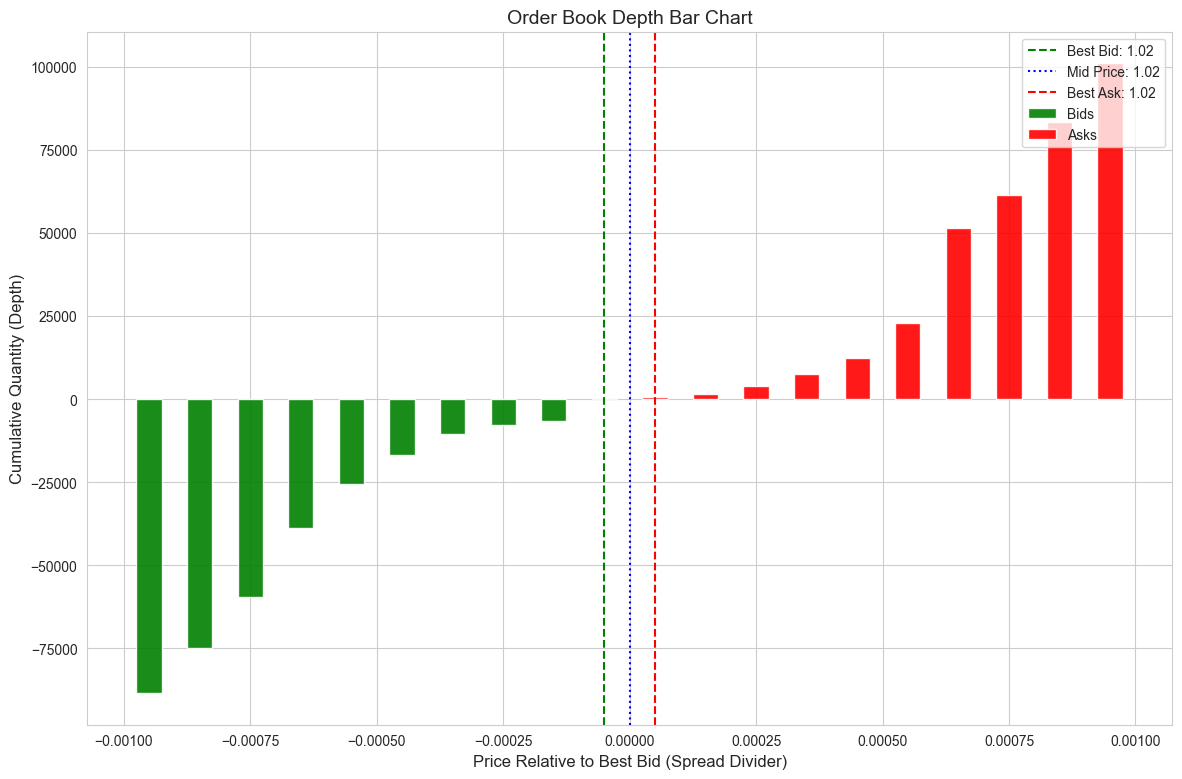

KeyboardInterrupt: 

In [211]:
while True:
    bids, asks, timestamp = ds.fetch_order_book(symbol[0], DOM)

    plot_order_book(np.array(bids), np.array(asks))

    time.sleep(SLEEP_INTERVAL)

In [34]:
def calculate_order_slices(symbol, total_size):
    x_min = symbol.min_position_size
    alpha = np.random.uniform(1.3, 1.5)

    while True:
        u = np.random.rand()

        order_size = x_min * (1 - u) ** (-1 / (alpha - 1))

        order_size = min(order_size, total_size)

        yield order_size

In [35]:
def plot_order_sizes(order_sizes):
    plt.figure(figsize=(10, 6))
    sns.histplot(order_sizes, bins=30, kde=False, color='blue', edgecolor='black', stat='density', alpha=0.6)
    plt.title('Distribution of Sampled Order Sizes')
    plt.xlabel('Order Size')
    plt.ylabel('Density')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

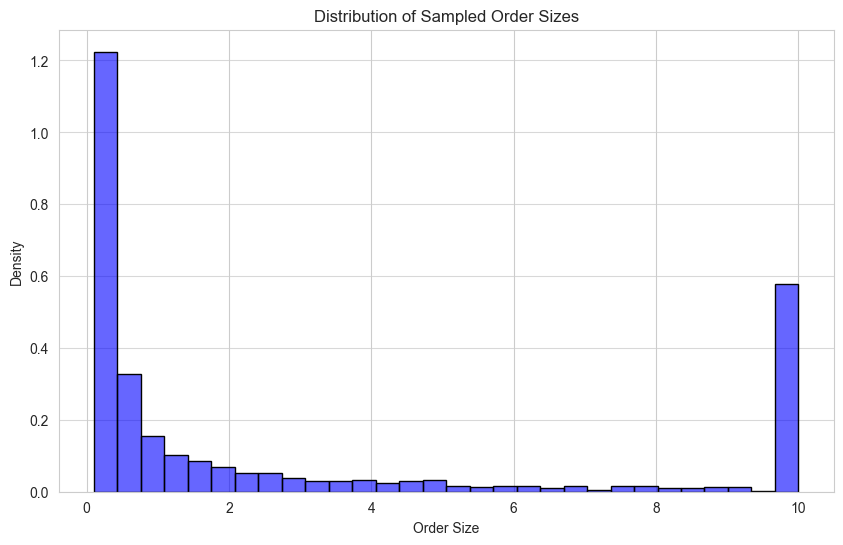

In [36]:
total_size = 10
num_samples = 1000

order_generator = calculate_order_slices(symbol=symbol[0], total_size=total_size)
order_sizes = [next(order_generator) for _ in range(num_samples)]

plot_order_sizes(order_sizes)


In [1861]:
SLEEP_INTERVAL = 8
ONE_HOUR = 3600
MULTI = 8
ORDER_BOOK_FILE = f'order_book_{symbol[0].name}_8h.csv'

In [1765]:
import pandas as pd
import time

def warm_up(symbol, DOM, duration=3600, sleep_interval=1):
    columns = ['timestamp'] + [item for i in range(1, DOM + 1) for item in [
        f'Ask {i} Price', 
        f'Ask {i} Size', 
        f'Bid {i} Price', 
        f'Bid {i} Size'
    ]]

    df = pd.DataFrame(columns=columns)

    start_time = time.time()
    end_time = start_time + duration

    while True:
        bids, asks, timestamp = ds.fetch_order_book(symbol, DOM)

        row = [timestamp]
        for i in range(DOM):
            row.extend([asks[i][0], asks[i][1], bids[i][0], bids[i][1]])

        df.loc[len(df)] = row

        time.sleep(sleep_interval)
        
        if time.time() > end_time:
            break

    return df

df = warm_up(symbol[0], DOM, ONE_HOUR * MULTI)

df.to_csv(ORDER_BOOK_FILE, index=False)

df.head()

KeyboardInterrupt: 

In [1862]:
def fe(df, k=8):
    df = df.copy()
    
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
   
    df['P'] = (df['Ask 1 Price'] + df['Bid 1 Price']) / 2
    df['PS'] = (df['Ask 1 Price'] - df['Bid 1 Price'])
    
    df['P+'] = df['P'].rolling(window=k).mean()
    df['P+'] = df['P+'].fillna(df['P'])

    df['d'] = (df['P+'] - df['P']) / df['P']
    
    df['R'] = (df['P'].shift(-1) - df['P']) / df['P']
    df['R'] = df['R'].fillna(0)
    
    df['D_B'] = df[[f'Bid {i} Size' for i in range(1, DOM + 1)]].sum(axis=1)
    df['D_A'] = df[[f'Ask {i} Size' for i in range(1, DOM + 1)]].sum(axis=1)

    df['DI'] = (df['D_B'] - df['D_A']) / (df['D_B'] + df['D_A'])

    df['BI'] = ((df['Bid 1 Price'] - df[f'Bid {DOM} Price']) - (df[f'Ask {DOM} Price'] - df['Ask 1 Price'])) / ((df['Bid 1 Price'] - df[f'Bid {DOM} Price']) + (df[f'Ask {DOM} Price'] - df['Ask 1 Price']))

    df['VI'] = (df['Bid 1 Size'] - df['Ask 1 Size']) / (df['Bid 1 Size'] + df['Ask 1 Size'])

    df['M'] = (df['Bid 1 Size'] / (df['Bid 1 Size'] + df['Ask 1 Size'])) * df['Ask 1 Price'] + (df['Ask 1 Size'] / (df['Bid 1 Size'] + df['Ask 1 Size'])) * df['Bid 1 Price']

    return df[['timestamp', 'P', 'PS', 'R', 'DI', 'BI', 'VI', 'M', 'd']]

df = pd.read_csv(ORDER_BOOK_FILE)

df_fe = fe(df)

df_fe.head()

,timestamp,P,PS,R,DI,BI,VI,M,d
0,2024-11-01 23:58:51.646,24.7875,0.005,0.000000,0.164004,0.000000e+00,-0.734379,24.785664,0.0
1,2024-11-01 23:59:00.147,24.7875,0.005,-0.000403,0.112261,0.000000e+00,-0.949671,24.785126,0.0
2,2024-11-01 23:59:08.746,24.7775,0.005,0.000000,0.147797,0.000000e+00,-0.006205,24.777484,0.0
3,2024-11-01 23:59:17.047,24.7775,0.005,0.000202,0.151567,0.000000e+00,0.009377,24.777523,0.0
4,2024-11-01 23:59:25.246,24.7825,0.005,0.000000,0.099785,3.947460e-14,-0.359788,24.781601,0.0


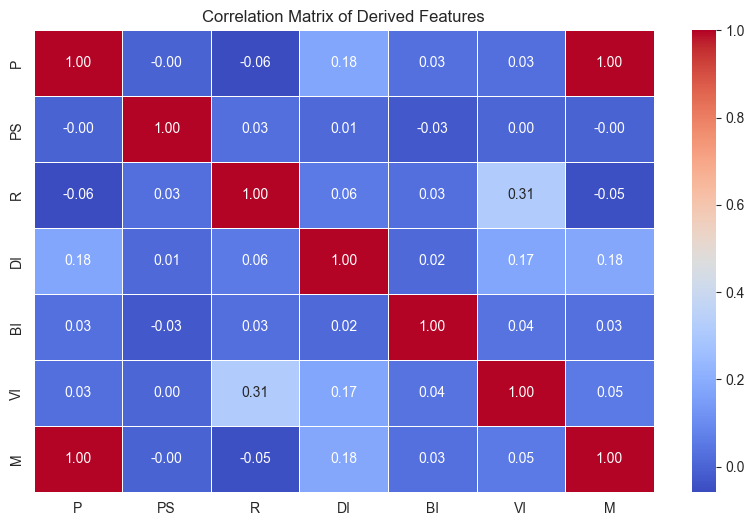

In [1863]:
def plot_correlation_matrix(df):
    plt.figure(figsize=(10, 6))
    corr_matrix = df.corr()
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Correlation Matrix of Derived Features")
    plt.show()

plot_correlation_matrix(df_fe.drop(columns=['timestamp', 'd']))

In [1864]:
def label_data(df, alpha):
    df = df.copy()
    df['y'] = np.where(df['d'] > alpha, 1, np.where(df['d'] < -alpha, -1, 0))
    return df

def plot_label_distribution(df):
    label_counts = df['y'].value_counts()
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'width_ratios': [1, 1]})
    
    sns.barplot(ax=axes[0], x=label_counts.index, y=label_counts.values, hue=label_counts.index, palette="viridis", dodge=False)
    axes[0].set_title('Class Distribution of Labels')
    axes[0].set_xlabel('Class Labels')
    axes[0].set_ylabel('Frequency')
    axes[0].legend(title="Labels", loc="upper right")
    
    sns.kdeplot(ax=axes[1], data=df, x='y', fill=True, alpha=0.5)
    axes[1].set_title('KDE Plot of Label Density')
    axes[1].set_xlabel('Class Labels')
    axes[1].set_ylabel('Density')
    
    plt.tight_layout()
    plt.show()

In [1865]:
import numpy as np
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args

best_alpha = None
best_imbalance_ratio = float('inf')

BIG_NUM = 1e10
NEUTRAL_PENALTY_WEIGHT = 0.15

def calculate_imbalance_ratio(label_counts):
    positive_count = label_counts.get(1, 0)
    negative_count = label_counts.get(-1, 0)
    neutral_count = label_counts.get(0, 0)
    total_count = positive_count + negative_count + neutral_count
    
    if total_count == 0:
        return BIG_NUM

    weight_pos = positive_count / total_count
    weight_neg = negative_count / total_count
    weight_neutral = neutral_count / total_count
    
    neutral_penalty = weight_neutral ** 2

    if positive_count == 0 or negative_count == 0:
        balance_penalty = BIG_NUM
    else:
        balance_penalty = (abs(weight_pos - weight_neg)) ** 2
    
    return min(balance_penalty + NEUTRAL_PENALTY_WEIGHT * neutral_penalty, BIG_NUM)

search_space = [Real(1e-6, 1e-2, "log-uniform", name="alpha")]

@use_named_args(search_space)
def optimize_alpha(alpha):
    df_l = label_data(df_fe, alpha)
    label_counts = df_l['y'].value_counts()
    imbalance_ratio = calculate_imbalance_ratio(label_counts)
    
    if np.isinf(imbalance_ratio) or np.isnan(imbalance_ratio):
        imbalance_ratio = BIG_NUM

    return imbalance_ratio

result = gp_minimize(
    func=optimize_alpha,
    dimensions=search_space,
    n_calls=50,
    n_random_starts=5,
    acq_func="EI",
    random_state=seed
)

best_alpha = result.x[0]
best_imbalance_ratio = result.fun

print(f"Best alpha: {best_alpha}")
print(f"Best imbalance ratio: {best_imbalance_ratio}")

Best alpha: 7.085175249502597e-06
Best imbalance ratio: 0.0005342211530562158


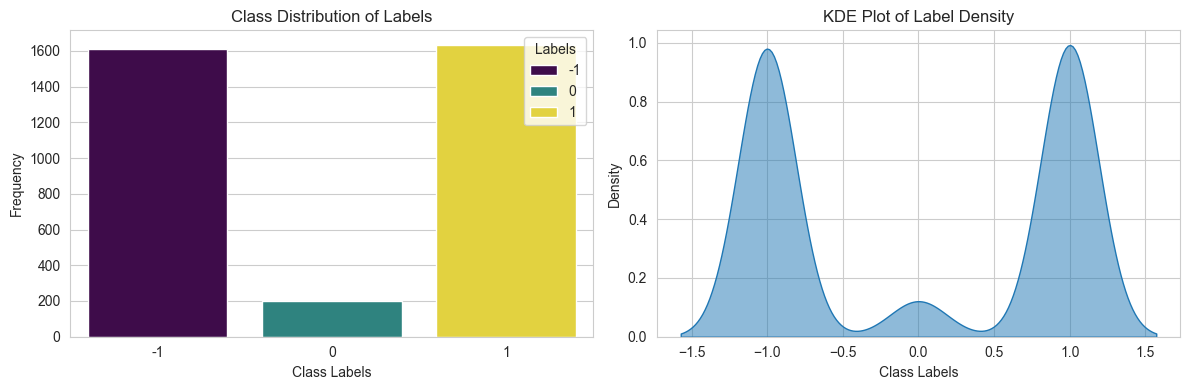

In [1866]:
df_l = label_data(df_fe, best_alpha)

plot_label_distribution(df_l)

In [1867]:
k = 10

def normalize(X, features):
    X_normalized = X.copy()

    for col in features:
        rolling_mean = X[col].rolling(window=k).mean()
        rolling_std = X[col].rolling(window=k).std()
        X_normalized[col] = (X[col] - rolling_mean) / (rolling_std + EPS)

    X_normalized = X_normalized.dropna()

    return X_normalized

In [1868]:
from sklearn.calibration import expit, label_binarize
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, hamming_loss
from imblearn.under_sampling import NeighbourhoodCleaningRule

def sigmoid_fn(preds):
    m, c = np.polyfit(preds, np.log(preds / (1 - preds)), 1)
    return expit(m * preds + c)

def sigmoid_calibration(y_proba):
    return np.apply_along_axis(sigmoid_fn, 0, y_proba)

def isotonic_calibration(y_proba, y_test, classes):
    n_samples, n_classes = y_proba.shape
    calibrated_probs = np.zeros((n_samples, n_classes))
    y_binarized = label_binarize(y_test, classes=classes)

    for i, _ in enumerate(classes):
        class_preds = y_proba[:, i]
        calibrator = IsotonicRegression(out_of_bounds="clip")
        calibrator.fit(class_preds, y_binarized[:, i])
        calibrated_probs[:, i] = calibrator.predict(class_preds)

    return calibrated_probs

def venn_abers_calibration(y_proba, y_test, classes):
    n_samples, n_classes = y_proba.shape
    calibrated_probs = np.zeros((n_samples, n_classes))
    y_binarized = label_binarize(y_test, classes=classes)

    for i, _ in enumerate(classes):
        class_preds = y_proba[:, i]
        
        calibrator_lower = IsotonicRegression(out_of_bounds="clip")
        calibrator_lower.fit(class_preds, y_binarized[:, i])
        lower_bound = calibrator_lower.predict(class_preds)

        calibrator_upper = IsotonicRegression(out_of_bounds="clip")
        calibrator_upper.fit(1 - class_preds, 1 - y_binarized[:, i])
        upper_bound = 1 - calibrator_upper.predict(1 - class_preds)

        calibrated_probs[:, i] = np.sqrt(lower_bound * upper_bound)

    return calibrated_probs

def calibrate_probabilities(y_predict_proba, y_test, classes, calibration_method):
    if calibration_method == 'venn_abers':
        return venn_abers_calibration(y_predict_proba, y_test, classes)
    elif calibration_method == 'isotonic':
        return isotonic_calibration(y_predict_proba, y_test, classes)
    elif calibration_method == 'sigmoid':
        return sigmoid_calibration(y_predict_proba)
    else:
        raise ValueError("Unsupported calibration method.")

def perform_kfold_cv(model, X, y, k_folds=5, calibration_method='venn_abers'):
    kf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=seed)
    classes = np.unique(y)
    probabilities = np.zeros((len(y), len(classes)))
    predictions = np.zeros(len(y))
    true_labels = np.zeros(len(y))

    for train_index, test_index in kf.split(X, y):
        X_train_full, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train_full, y_test = y.iloc[train_index], y.iloc[test_index]

        sampler = NeighbourhoodCleaningRule()

        X_train_sampled, y_train_sampled = sampler.fit_resample(X_train_full, y_train_full)

        model.fit(X_train_sampled, y_train_sampled)

        y_predict_proba = model.predict_proba(X_test)

        calibrated_probs = calibrate_probabilities(y_predict_proba, y_test, classes, calibration_method)

        predictions[test_index] = classes[np.argmax(calibrated_probs, axis=1)]
        probabilities[test_index] = calibrated_probs

        true_labels[test_index] = y_test.values

    return predictions, probabilities, true_labels

def calculate_metrics(predictions, probabilities, y_true):
    y_true_binarized = label_binarize(y_true, classes=[-1, 0, 1])

    def brier_loss_calc(y_true, pred):
        return ((y_true - pred)**2).mean()

    accuracy = accuracy_score(y_true, predictions)
    precision = precision_score(y_true, predictions, average='weighted', zero_division=0)
    recall = recall_score(y_true, predictions, average='weighted', zero_division=0)
    f1 = f1_score(y_true, predictions, average='weighted', zero_division=0)
    brier = brier_loss_calc(y_true, predictions)
    roc_auc = roc_auc_score(y_true_binarized, probabilities, average='weighted', multi_class='ovr')
    hamming = hamming_loss(y_true, predictions)

    return accuracy, precision, recall, f1, brier, roc_auc, hamming

def plot_regime(df, model_name):
    plt.figure(figsize=(16, 8))

    plt.plot(df['timestamp'], df['P'], color='gray', alpha=0.5, label='Feature P')

    plt.fill_between(df['timestamp'], df['P'], where=(df['regime'] == 1), 
                    color='green', alpha=0.3, label='Long')
    plt.fill_between(df['timestamp'], df['P'], where=(df['regime'] == -1), 
                    color='red', alpha=0.3, label='Short')
    
    plt.fill_between(df['timestamp'], df['P'], where=(df['regime'] == 0), 
                    color='blue', alpha=0.3, label='Range')

    plt.title(f'({model_name}) P and Regime')
    plt.xlabel('TS')
    plt.ylabel('P')
    plt.legend()
    plt.grid()

    plt.show()

def plot_roc_auc(probabilities, true_labels):
    y_test_bin = label_binarize(true_labels,  classes=[-1, 0, 1])
    
    roc_auc = roc_auc_score(y_test_bin, probabilities, average='macro', multi_class='ovr')

    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    
    for i in range(y_test_bin.shape[1]):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], probabilities[:, i])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0

    plt.figure(figsize=(8, 5))
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average ROC Curve')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

In [1896]:
features = ['P', 'PS', 'R', 'DI', 'BI', 'VI']

X = df_l[features]
y = df_l['y']

X_normalized = normalize(X, features)

y = y.loc[X_normalized.index]

timestamps = pd.to_datetime(df_l.loc[X_normalized.index]['timestamp'])


Accuracy: 0.9264
Precision: 0.9141
Recall: 0.9264
F1 Score: 0.9117
Brier Score: 0.1391
ROC-AUC Score: 0.9857
Hamming: 0.0736


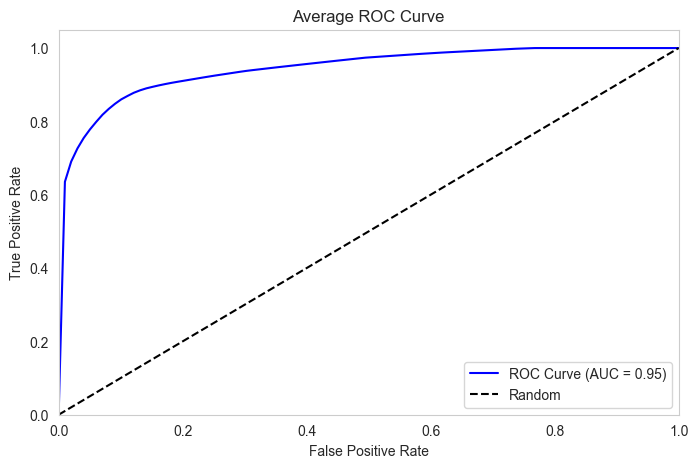

In [1897]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

k_folds = 5
calibration = 'venn_abers'

model = OneVsRestClassifier(LogisticRegression(solver='lbfgs', random_state=seed))

predictions, probabilities, true_labels = perform_kfold_cv(model, X_normalized, y, k_folds, calibration)

accuracy, precision, recall, f1, brier, roc_auc, hamming = calculate_metrics(predictions, probabilities, true_labels)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Brier Score: {brier:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")
print(f"Hamming: {hamming:.4f}")

plot_roc_auc(probabilities, true_labels)

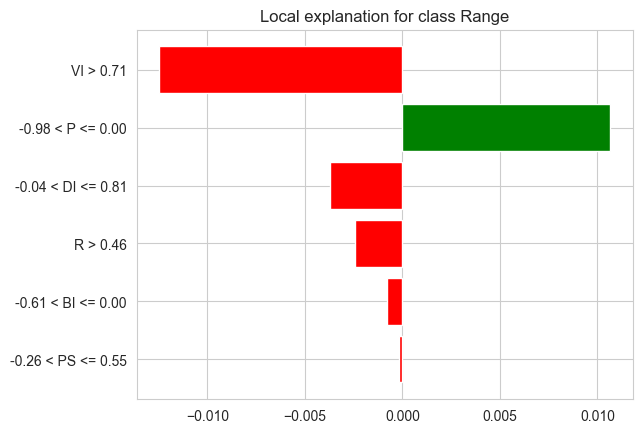

In [1898]:
from lime.lime_tabular import LimeTabularExplainer

lime_explainer = LimeTabularExplainer(X_normalized.values, mode="classification", 
                                      feature_names=features, class_names=['Short', 'Range', 'Long'], 
                                      discretize_continuous=True)

def lime_predict_proba(data):
    data_df = pd.DataFrame(data, columns=features)
    return model.predict_proba(data_df)

random_index = np.random.randint(0, len(X_normalized))
exp = lime_explainer.explain_instance(X_normalized.iloc[random_index].values, lime_predict_proba, num_features=len(features))

exp.show_in_notebook(show_table=True)
exp.as_pyplot_figure()

plt.show()

In [1899]:
from sklearn.ensemble import RandomForestClassifier

k_folds = 5

rf_model = RandomForestClassifier(random_state=seed)

perform_kfold_cv(rf_model, X_normalized, y, k_folds)

rf_imp = pd.DataFrame({
    "feature": X_normalized.columns,
    "importance": rf_model.feature_importances_
})

rf_imp = rf_imp.sort_values(by="importance", ascending=False).reset_index(drop=True)

rf_imp.head(10)

,feature,importance
0,P,0.726565
1,R,0.106277
2,DI,0.090243
3,VI,0.030286
4,BI,0.026098
5,PS,0.020531


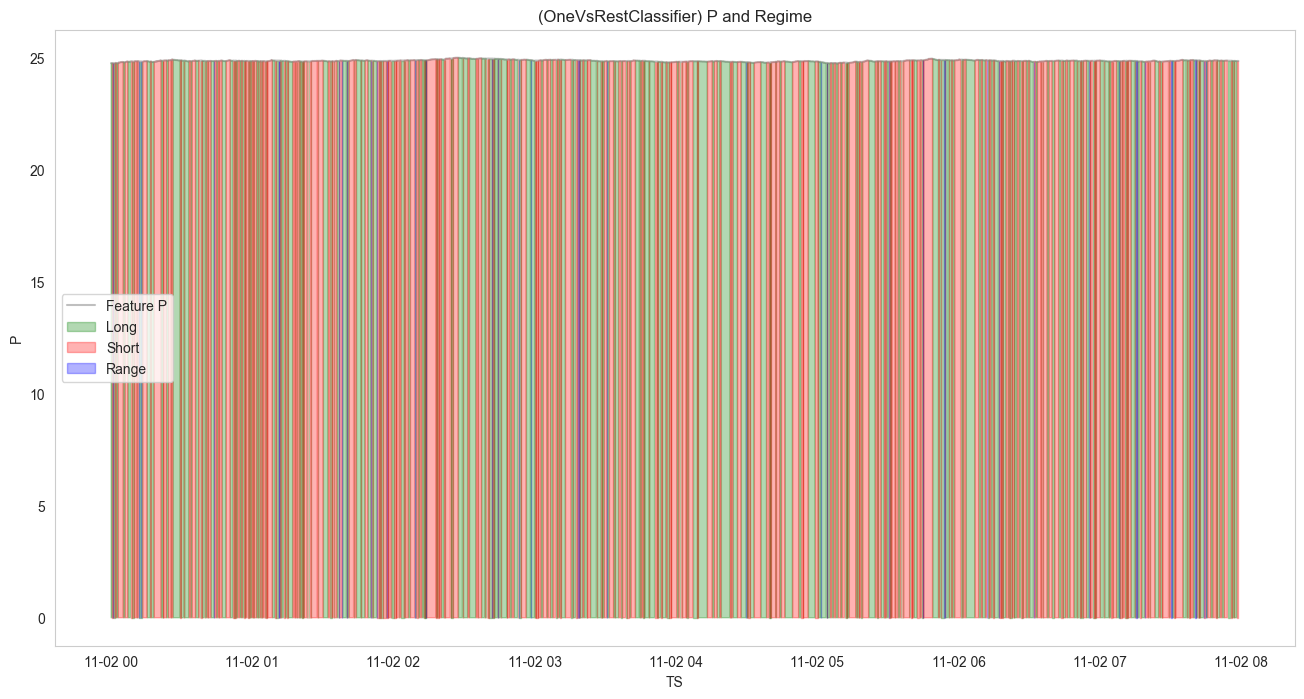

In [1900]:
dpred = df_l.loc[X_normalized.index].copy()
dpred['regime'] = predictions

plot_regime(dpred, model.__class__.__name__)

In [1901]:
import numpy as np
from scipy.optimize import minimize

class HawkesProcess:
    def __init__(self, mu=0.1, alpha=0.5, beta=1.0, reg_alpha=1e-2, reg_beta=1e-2):
        self.mu = mu
        self.alpha = alpha
        self.beta = beta
        self.event_times = []
        self.reg_alpha = reg_alpha
        self.reg_beta = reg_beta

    def intensity(self, t):
        if not self.event_times:
            return self.mu

        time_diff = t - np.array(self.event_times)

        return self.mu + np.sum(self.alpha * np.exp(-self.beta * time_diff))

    def simulate(self, T_sim):
        self.event_times = []
        t = 0

        while t < T_sim:
            lambda_t = self.intensity(t)
            x = np.random.exponential(1 / lambda_t)
            t += x
            
            if t < T_sim:
                self.event_times.append(t)

    def fit(self, observed_events):
        if not np.all(np.diff(observed_events) >= 0):
            raise ValueError("observed_events must be sorted in non-decreasing order.")
        
        if np.any(observed_events < 0):
            raise ValueError("observed_events must contain non-negative timestamps.")

        T_max = observed_events[-1] if len(observed_events) > 0 else 1.0
        event_density = len(observed_events) / T_max if T_max > 0 else 0
        
        ada_reg_alpha = self.reg_alpha / (1 + event_density)

        def log_likelihood(params):
            mu, alpha, beta = params
            ll = 0

            for t_k in observed_events:
                previous_events = observed_events[observed_events < t_k]
                previous_events = np.array(previous_events, dtype=np.float64)
                
                if len(previous_events) > 0:
                    decay_terms = alpha * np.exp(-beta * (t_k - previous_events))
                    lambda_t_k = mu + np.sum(decay_terms)
                else:
                    lambda_t_k = mu
                
                if lambda_t_k <= 0:
                    return np.inf
                
                ll += np.log(lambda_t_k)

            ll -= mu * T_max + (alpha / beta) * np.sum(1 - np.exp(-beta * (T_max - observed_events)))
            ll -= ada_reg_alpha * alpha**2 + self.reg_beta * beta**2

            return -ll

        initial_params = [self.mu, self.alpha, self.beta]
        bounds = [(1e-8, None), (1e-8, None), (1e-8, None)]

        result = minimize(log_likelihood, initial_params, bounds=bounds, method='L-BFGS-B')

        self.mu, self.alpha, self.beta = result.x


In [1902]:
def create_prob_edge_index(event_times, mu=0.1, alpha=0.5, beta=1.0, sigmoid_scaling=0.5, exp_cap=1e6):
    n = len(event_times)

    event_times_tensor = event_times if isinstance(event_times, torch.Tensor) else torch.tensor(event_times, dtype=torch.float32)
    
    time_matrix = event_times_tensor.unsqueeze(1) - event_times_tensor.unsqueeze(0)
    mask = torch.tril(torch.ones_like(time_matrix), diagonal=-1).bool()
    
    intensities = torch.zeros((n, n), dtype=torch.float32)
    exp_terms = torch.exp(-beta * time_matrix[mask]).clamp(max=exp_cap).to(intensities.dtype)
    intensities[mask] = mu + alpha * exp_terms

    min_intensity, max_intensity = intensities.min(), intensities.max()
    intensities = (intensities - min_intensity) / (max_intensity - min_intensity + EPS)
    
    probabilities = torch.sigmoid(sigmoid_scaling * intensities)
    
    random_values = torch.rand((n, n))
    selected_edges = (random_values < probabilities) & mask
    
    edge_list = selected_edges.nonzero(as_tuple=False).t()
    edge_weights = probabilities[selected_edges]
    
    assert edge_list.shape[1] == edge_weights.shape[0], "Mismatch between edge_list and edge_weights."
    
    return edge_list, edge_weights

In [1903]:
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

BATCH_SIZE = 32
TEST_RATIO = 0.2
MU = 0.1
ALPHA = 0.5
BETA = 1.0

event_times = torch.tensor(timestamps.to_numpy().astype(float), dtype=torch.float64)
y_mapped = y.replace({-1: 2})

h = HawkesProcess(MU, ALPHA, BETA)
h.fit(event_times.numpy())

print(f"Hawkes with mu: {h.mu} alpha: {h.alpha} beta: {h.beta}")

sampler = NeighbourhoodCleaningRule()
X_sampled, y_sampled = sampler.fit_resample(X_normalized.to_numpy(), y_mapped.values)
event_times_sampled = event_times[sampler.sample_indices_]

assert np.all(np.diff(event_times_sampled) >= 0) == True

X_t = torch.tensor(X_sampled, dtype=torch.float)
y_t = torch.tensor(y_sampled, dtype=torch.long)

X_train, X_test, y_train, y_test, event_times_train, event_times_test = train_test_split(
    X_t, y_t, event_times_sampled, test_size=TEST_RATIO, random_state=seed, stratify=y_t
)

train_data_list, test_data_list = [], []

def create_graph_samples(X, y, event_times, h, batch_size=BATCH_SIZE):
    data_list = []

    for i in range(0, len(X), batch_size):
        X_batch = X[i:i + batch_size]
        y_batch = y[i:i + batch_size]
        event_times_batch = event_times[i:i + batch_size]
        
        edge_index, edge_attr_weights = create_prob_edge_index(event_times_batch, mu=h.mu, alpha=h.alpha, beta=h.beta)
        
        num_edges = edge_index.shape[1]
        edge_attr = edge_attr_weights[:num_edges].view(-1)

        PS = X_batch[:, features.index('PS')]
        VI = X_batch[:, features.index('VI')]
        BI = X_batch[:, features.index('BI')]
        
        PS_edges = PS[edge_index[0]]
        VI_edges = VI[edge_index[0]]
        BI_edges = BI[edge_index[0]]

        edge_attr = torch.stack((edge_attr, PS_edges, VI_edges, BI_edges), dim=1)

        data = Data(x=X_batch, edge_index=edge_index, edge_attr=edge_attr, y=y_batch)
        data_list.append(data)
    
    return data_list

train_data_list = create_graph_samples(X_train, y_train, event_times_train, h)
test_data_list = create_graph_samples(X_test, y_test, event_times_test, h)

train_dataloader = DataLoader(train_data_list, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_data_list, batch_size=1)

Hawkes with mu: 1e-08 alpha: 1e-08 beta: 1.1826919101943718


In [1904]:
batch = next(iter(train_dataloader))

print("Node features (X):", batch.x.shape)
print("Edge index:", batch.edge_index.shape)
print("Edge attr:", batch.edge_attr.shape)
print("y:", batch.y.shape)
print("batch:", batch.batch)

unique_nodes = batch.edge_index.unique()

print("Unique node indices:", unique_nodes)
print("Max node index:", unique_nodes.max().item())

Node features (X): torch.Size([32, 6])
Edge index: torch.Size([2, 293])
Edge attr: torch.Size([293, 4])
y: torch.Size([32])
batch: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
Unique node indices: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])
Max node index: 31


In [1905]:
L = 6

def create_pairs(data_list, L, batch_size):
    size_map = {}

    for graph in data_list:
        size = graph.num_nodes
        
        if size not in size_map:
            size_map[size] = []
        
        size_map[size].append(graph)
    
    fixed_size_pairs = []

    for graphs in size_map.values():
        if len(graphs) >= L:
            for i in range(0, len(graphs) - L, batch_size):
                if i + L < len(graphs):
                    for j in range(batch_size):
                        if i + j + L < len(graphs):
                            fixed_size_pairs.append((graphs[i + j], graphs[i + j + L]))

    return fixed_size_pairs

train_pairs = create_pairs(train_data_list, L, BATCH_SIZE)
test_pairs = create_pairs(test_data_list, L, BATCH_SIZE)

train_pairs_dataloader = DataLoader(train_pairs, batch_size=1, shuffle=True)
test_pairs_dataloader = DataLoader(test_pairs, batch_size=1)

In [1906]:
next(iter(train_pairs_dataloader))

[DataBatch(x=[32, 6], edge_index=[2, 277], edge_attr=[277, 4], y=[32], batch=[32], ptr=[2]),
 DataBatch(x=[32, 6], edge_index=[2, 291], edge_attr=[291, 4], y=[32], batch=[32], ptr=[2])]

In [1907]:
import torch.nn as nn

class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-BCE_loss)

        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        if self.reduction == 'mean':
            return F_loss.mean()
        elif self.reduction == 'sum':
            return F_loss.sum()
        return F_loss

In [1931]:
class GCPDLoss(nn.Module):
    def __init__(self, margin=1.0, positive_weight=1.0, negative_weight=1.0, mse_weight=0.5, l2_reg_weight=0.01, reduction='mean'):
        super(GCPDLoss, self).__init__()
        self.margin = margin
        self.positive_weight = positive_weight
        self.negative_weight = negative_weight
        self.reduction = reduction
        self.l2_reg_weight = l2_reg_weight
        self.mse_weight = mse_weight
        self.mse_loss = nn.MSELoss(reduction='none')

    def forward(self, emb1, emb2, target):
        distance = nn.functional.pairwise_distance(emb1, emb2, p=2)

        pos_loss = self.positive_weight * target * torch.pow(distance, 2)
        neg_loss = self.negative_weight * (1 - target) * torch.pow(torch.clamp(self.margin - distance, min=0.0), 2)

        loss = pos_loss + neg_loss

        loss += self.l2_reg_weight * (torch.norm(emb1 - emb2, p=2) ** 2)
        loss += self.mse_weight * self.mse_loss(emb1, emb2).mean(dim=1)
        
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

In [1974]:
import math
from torch_geometric import nn as gnn
from torch import nn
import torch.nn.functional as F

class GATEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_heads, num_layers, dropout=0.2, activation=F.relu):
        super(GATEncoder, self).__init__()
        self.num_layers = num_layers
        self.activation = activation

        self.convs = nn.ModuleList()
        
        self.convs.append(gnn.GATConv(input_dim, hidden_dim, heads=num_heads, dropout=dropout))
        
        for _ in range(1, num_layers - 1):
            self.convs.append(gnn.GATConv(hidden_dim * num_heads, hidden_dim, heads=num_heads, dropout=dropout, residual=True))
        
        self.convs.append(gnn.GATConv(hidden_dim * num_heads, output_dim, heads=num_heads, dropout=dropout, concat=False))

        self.norms = nn.ModuleList([gnn.GraphNorm(hidden_dim * num_heads) for _ in range(num_layers - 1)])

    def forward(self, x, edge_index, edge_attr):
        for i, conv in enumerate(self.convs[:-1]):
            x = conv(x, edge_index, edge_attr)
            x = self.activation(x)
            x = self.norms[i](x)
            x = F.dropout(x, p=0.2, training=self.training)

        x = self.convs[-1](x, edge_index, edge_attr)
        return x
    
class PE(nn.Module):
    def __init__(self, dim, max_len):
        super(PE, self).__init__()
        
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, dim, 2) * (-math.log(10000.0) / dim))
        
        pe = torch.zeros(max_len, dim)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.pe = nn.Parameter(pe.unsqueeze(0), requires_grad=True)

    def forward(self, x):
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len, :]

class TopKModule(nn.Module):
    def __init__(self, k, embed_dim, num_heads, max_len):
        super(TopKModule, self).__init__()
        self.k = k
        self.pe = PE(embed_dim, max_len=max_len)
        self.self_att = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True)

    def forward(self, emb1, emb2):
        dist = torch.cdist(emb1, emb2, p=2)
        
        top_dist, _ = torch.topk(dist, self.k, dim=1, largest=True)
        
        top_dist = self.pe(top_dist.unsqueeze(1))

        x_att, _ = self.self_att(top_dist, top_dist, top_dist)
        
        x = torch.mean(x_att, dim=1)
        
        return x
    
class SimilarityModule(nn.Module):
    def __init__(self, output_dim, num_heads=5, k=10, max_len=500):
        super(SimilarityModule, self).__init__()
        self.top_k = TopKModule(k=k, embed_dim=k, num_heads=num_heads, max_len=max_len)

        self.fc1 = nn.Linear(k, output_dim)
        self.ln1 = nn.BatchNorm1d(output_dim)
        
        self.fc2 = nn.Linear(output_dim, output_dim // 2)
        self.ln2 = nn.BatchNorm1d(output_dim // 2)
        
        self.output_fc = nn.Linear(output_dim // 2, 1)

    def forward(self, emb1, emb2):
        x = self.top_k(emb1, emb2)

        x = F.gelu(self.ln1(self.fc1(x)))
        x = F.gelu(self.ln2(self.fc2(x)))
        x = self.output_fc(x)

        out = torch.sum(x, dim=1, keepdim=True)

        return out
    
class GCPD(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_heads, num_layers, top_k):
        super(GCPD, self).__init__()
        self.encoder = GATEncoder(input_dim, hidden_dim, output_dim, num_heads, num_layers)
        self.similarity_module = SimilarityModule(output_dim, top_k)

    def forward(self, g1, g2):
        emb1 = self.encoder(g1[0], g1[1], g1[2])
        emb2 = self.encoder(g2[0], g2[1], g2[2])

        return self.similarity_module(emb1, emb2)

In [1975]:
import torch.optim as optim
from notebooks.train import CheckPoint, EarlyStop, SnapshotManager

n_snapshots = 3
patience = 16
snapshot_interval = 5
epoch = 20

INPUT = X_train.shape[1]
HIDDEN = 64
NUM_HEADS = 8
NUM_LAYERS = 4
OUTPUT = 16
TOP_K = 10
LR = 0.0001

model_gcpd = GCPD(INPUT, HIDDEN, OUTPUT, NUM_HEADS, NUM_LAYERS, TOP_K)
optimizer = optim.Adam(model_gcpd.parameters(), lr=LR)
criterion = GCPDLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epoch)

snapshot_manager = SnapshotManager(model_gcpd, n_snapshots=n_snapshots)
early_stop = EarlyStop(patience=patience)
checkpoint = CheckPoint(
    snapshot_manager=snapshot_manager, snapshot_interval=snapshot_interval
)
device = 'mps' if torch.backends.mps.is_available() else 'cpu'

In [1976]:
import gc
from contextlib import contextmanager

@contextmanager
def autocleanup(*tensors):
    yield
    for tensor in tensors:
        del tensor
    if torch.backends.mps.is_available():
        torch.mps.empty_cache()
    elif torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()

In [1977]:
from notebooks.train import Trainer

class GCPDTrainer(Trainer):
    def __init__(self, *args, acc_steps=4, **kwargs):
        super().__init__(*args, **kwargs)
        self.acc_steps = acc_steps

    def train_epoch(self):
        self.model.train()
        running_train_loss = 0.0
        num_batches = len(self.train_dataloader)
        acc_loss = 0.0

        for batch_idx, batch in enumerate(self.train_dataloader):
            g1 = (batch[0].x.to(device), batch[0].edge_index.to(device), batch[0].edge_attr.to(device))
            g2 = (batch[1].x.to(device), batch[1].edge_index.to(device), batch[1].edge_attr.to(device))
            
            with autocleanup(g1, g2):
                emb1 = self.model.encoder(g1[0], g1[1], g1[2])
                emb2 = self.model.encoder(g2[0], g2[1], g2[2])

                output = self.model.similarity_module(emb1, emb2)
                scores = torch.sigmoid(output)
                
                loss = self.calc_loss(emb1, emb2, self.criterion, scores)

                acc_loss += loss.item()

                loss.backward()

                if (batch_idx + 1) % self.acc_steps == 0 or (batch_idx + 1) == num_batches:
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                    self.optimizer.step()
                    self.optimizer.zero_grad()
                    running_train_loss += acc_loss
                    acc_loss = 0.0

                del batch, output, loss, emb1, emb2

        avg_train_loss = running_train_loss / max(1, (num_batches + self.acc_steps - 1) // self.acc_steps)

        return avg_train_loss

    def valid_epoch(self):
        return 0.0
    
    @staticmethod
    def calc_loss(emb1, emb2, criterion, scores):
        pseudo_labels = (scores > 0.5).float()

        targets = pseudo_labels.view(-1) 
        
        loss = criterion(emb1, emb2, targets)

        return loss
    

In [1978]:
trainer = GCPDTrainer(
    model_gcpd,
    train_pairs_dataloader,
    test_pairs_dataloader,
    optimizer,
    scheduler,
    criterion,
    early_stop,
    checkpoint,
    device=device
)


No snapshots found, starting from scratch.


In [1979]:
trainer.train(epoch)

Start training with epochs 20
Epoch 1/20, Train_Loss: 21.6143, Val_Loss: 0.0000
Saved improved snapshot: snapshots/GCPD_epoch_1_improved.pth
Epoch 2/20, Train_Loss: 15.7754, Val_Loss: 0.0000
Saved improved snapshot: snapshots/GCPD_epoch_2_improved.pth
Epoch 3/20, Train_Loss: 14.0194, Val_Loss: 0.0000
Saved improved snapshot: snapshots/GCPD_epoch_3_improved.pth
Epoch 4/20, Train_Loss: 12.8136, Val_Loss: 0.0000
Saved improved snapshot: snapshots/GCPD_epoch_4_improved.pth
Removed old improved snapshot: snapshots/GCPD_epoch_1_improved.pth
Removed old improved snapshot: snapshots/GCPD_epoch_2_improved.pth
Removed old improved snapshot: snapshots/GCPD_epoch_3_improved.pth
Epoch 5/20, Train_Loss: 11.8112, Val_Loss: 0.0000
Saved improved snapshot: snapshots/GCPD_epoch_5_improved.pth
Saved periodic snapshot: snapshots/GCPD_epoch_5_periodic.pth
Epoch 6/20, Train_Loss: 11.4422, Val_Loss: 0.0000
Saved improved snapshot: snapshots/GCPD_epoch_6_improved.pth
Removed old improved snapshot: snapshots/G

In [1980]:
def extract_embeddings_and_scores(dataloader, model, device):
    model.eval()
    all_emb1 = []
    all_emb2 = []
    all_scores = []

    with torch.no_grad():
        for batch in dataloader:
            g1 = (batch[0].x.to(device), batch[0].edge_index.to(device), batch[0].edge_attr.to(device))
            g2 = (batch[1].x.to(device), batch[1].edge_index.to(device), batch[1].edge_attr.to(device))

            emb1 = model.encoder(g1[0], g1[1], g1[2])
            emb2 = model.encoder(g2[0], g2[1], g2[2])

            output = model.similarity_module(emb1, emb2)

            scores = torch.sigmoid(output)

            all_emb1.append(emb1.cpu().numpy())
            all_emb2.append(emb2.cpu().numpy())
            all_scores.append(scores.cpu().numpy())

    all_emb1 = np.concatenate(all_emb1)
    all_emb2 = np.concatenate(all_emb2)
    all_scores = np.concatenate(all_scores)

    return all_emb1, all_emb2, all_scores

Loaded snapshot: snapshots/GCPD_epoch_20_improved.pth
Imbalance ratio: 1.4654840883900437


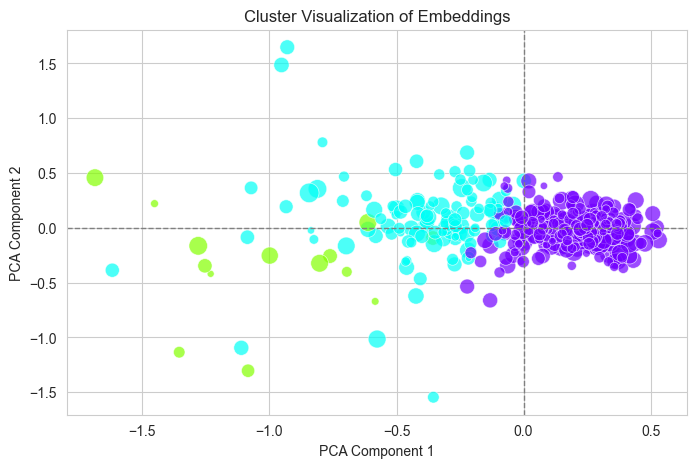

In [1981]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

model_gcpd_inf = GCPD(INPUT, HIDDEN, OUTPUT, NUM_HEADS, NUM_LAYERS, TOP_K)
model_gcpd_inf.to(device)

snapshot_manager = SnapshotManager(model_gcpd_inf)
snapshot_manager.load_latest()

emb1, emb2, scores = extract_embeddings_and_scores(test_pairs_dataloader, model_gcpd_inf, device)

positive_scores = scores[scores > 0.5].sum()
negative_scores = scores[scores <= 0.5].sum()
imb_ratio = positive_scores / (negative_scores + EPS)

print(f"Imbalance ratio: {imb_ratio}")

combo = np.concatenate((emb1, emb2), axis=1)

num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=seed)
kmeans.fit(combo)

cluster_labels = kmeans.labels_

pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(combo)

df_score = pd.DataFrame(reduced_embeddings, columns=['Component 1', 'Component 2'])
df_score['Cluster'] = cluster_labels
df_score['Score'] = np.concatenate((scores[scores > 0.5], scores[scores <= 0.5]), axis=0)

plt.figure(figsize=(8, 5))

palette = sns.color_palette("hsv", num_clusters)

sns.scatterplot(data=df_score, x='Component 1', y='Component 2', hue='Cluster', size='Score', sizes=(20, 200),
                palette=palette, alpha=0.7, legend=False)

plt.title('Cluster Visualization of Embeddings')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.axhline(0, color='gray', lw=1, ls='--')
plt.axvline(0, color='gray', lw=1, ls='--')
plt.grid(True)

plt.show()


In [1631]:
import torch
from torch_geometric.nn import GATConv, SAGPooling, global_max_pool
from torch import nn
import torch.nn.functional as F

class JumpDiffusionLayer(nn.Module):
    def __init__(self, out_channels, jump_intensity, jump_scale, volatility=0.1, alpha=0.1, beta=0.85, asymmetry=0.1, learnable=True):
        super(JumpDiffusionLayer, self).__init__()
        self.jump_intensity_up = nn.Parameter(torch.tensor(jump_intensity), requires_grad=learnable)
        self.jump_intensity_down = nn.Parameter(torch.tensor(jump_intensity * asymmetry), requires_grad=learnable)
        self.jump_scale = nn.Parameter(torch.tensor(jump_scale), requires_grad=learnable)
        self.volatility = nn.Parameter(torch.tensor(volatility), requires_grad=learnable)
        
        self.alpha = alpha
        self.beta = beta
        self.eps = np.finfo(float).eps
                
        self.layer_norm = nn.LayerNorm(out_channels)

    def forward(self, x):
        if x.ndim != 2:
            raise ValueError("Input x must be a 2D tensor with shape [batch_size, features]")

        returns = (x - x.roll(shifts=1, dims=0)) / (x.roll(shifts=1, dims=0) + self.eps)
        returns[0] = 0
        squared_returns = returns ** 2

        current_volatility = torch.sqrt(self.alpha * squared_returns.mean(dim=0) + self.beta * (self.volatility ** 2))

        adj_jump_intensity_up = torch.clamp(self.jump_intensity_up * current_volatility / self.volatility, min=0)
        adj_jump_intensity_down = torch.clamp(self.jump_intensity_down * current_volatility / self.volatility, min=0)

        jumps_up = torch.poisson(adj_jump_intensity_up) * torch.normal(mean=0, std=self.jump_scale).clamp(-3, 3)
        jumps_down = torch.poisson(adj_jump_intensity_down) * torch.normal(mean=0, std=self.jump_scale).clamp(-3, 3)
        x_jump = x.clone()
        x_jump += F.elu(jumps_up) * adj_jump_intensity_up - F.elu(jumps_down) * (1 - adj_jump_intensity_down)
       
        return self.layer_norm(x_jump)

class CrossAttentionLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super(CrossAttentionLayer, self).__init__()
        self.cross_attention = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.linear = nn.Linear(embed_dim, embed_dim)
        self.layer_norm1 = nn.LayerNorm(embed_dim)
        self.layer_norm2 = nn.LayerNorm(embed_dim)

    def forward(self, query, key, value):
        attn_output, _ = self.cross_attention(query, key, value)
        query = query + attn_output
        query = self.layer_norm1(query)

        complex_output = self.linear(query)
        complex_output = F.gelu(complex_output)
        query = query + complex_output

        return self.layer_norm2(query)
    
class FusionLayer(nn.Module):
    def __init__(self, in_channels1, in_channels2, out_channels, attention_heads=4, dropout=0.1):
        super(FusionLayer, self).__init__()
        self.fc1_1d = nn.Linear(in_channels1, out_channels)
        self.fc2_2d = nn.Linear(in_channels2, out_channels)

        self.self_attention_1d = nn.MultiheadAttention(embed_dim=out_channels, num_heads=attention_heads, dropout=dropout)
        self.self_attention_2d = nn.MultiheadAttention(embed_dim=out_channels, num_heads=attention_heads, dropout=dropout)
        self.cross_attention = CrossAttentionLayer(embed_dim=out_channels, num_heads=attention_heads, dropout=dropout)
        
        self.fc_fuse1 = nn.Linear(out_channels * 2, out_channels)
        self.fc_fuse2 = nn.Linear(out_channels, out_channels)
        self.layer_norm = nn.LayerNorm(out_channels)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x1d, x2d):
        x1d_transformed = F.relu(self.fc1_1d(x1d.view(x1d.size(0), -1)))
        x2d_transformed = F.relu(self.fc2_2d(x2d.view(x2d.size(0), -1)))

        x1d_self_attended, _ = self.self_attention_1d(x1d_transformed.unsqueeze(0), x1d_transformed.unsqueeze(0), x1d_transformed.unsqueeze(0))
        x2d_self_attended, _ = self.self_attention_2d(x2d_transformed.unsqueeze(0), x2d_transformed.unsqueeze(0), x2d_transformed.unsqueeze(0))

        fused = self.cross_attention(x1d_self_attended, x2d_self_attended, x2d_self_attended)
        fused = torch.cat((fused.squeeze(0), x1d_transformed), dim=1)
        fused = self.dropout(self.layer_norm(F.relu(self.fc_fuse1(fused))))
        fused = self.fc_fuse2(fused)

        return fused
    
class GNNLayer(nn.Module):
    def __init__(self, in_channels, out_channels, heads=4, dropout=0.1, ratio=0.5):
        super(GNNLayer, self).__init__()
        self.gat_conv1 = GATConv(in_channels, out_channels, heads=heads, dropout=dropout)
        self.gat_conv2 = GATConv(out_channels * heads, out_channels, heads=heads, dropout=dropout)

        self.pool = SAGPooling(in_channels=out_channels * heads, ratio=ratio)
        self.fc1 = nn.Linear(out_channels * heads, out_channels)
        self.layer_norm = nn.LayerNorm(out_channels)

    def forward(self, x, edge_index, edge_attr):
        x_gat = self.gat_conv1(x, edge_index, edge_attr)
        x_gat = self.gat_conv2(x_gat, edge_index, edge_attr)

        x_pooled, edge_index, edge_attr, _, _, _ = self.pool(x_gat, edge_index, edge_attr)
        x_pooled = global_max_pool(x_pooled, batch=None)

        x_fc = F.relu(self.fc1(x_pooled))
        x_fc = self.layer_norm(x_fc)

        return x_fc

class ORCA(nn.Module):
    def __init__(self, in_channels, conv_out_channels, gat_heads=4, gat_dropout=0.1, classes=3, jump_intensity=0.1, jump_scale=0.05):
        super(ORCA, self).__init__()

        self.conv_block1_2d = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=conv_out_channels, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(conv_out_channels),

            nn.Conv2d(in_channels=conv_out_channels, out_channels=conv_out_channels, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(conv_out_channels),
        )

        self.residual1 = nn.Conv2d(in_channels, conv_out_channels, kernel_size=1)

        self.conv_block2_2d = nn.Sequential(
            nn.Conv2d(in_channels=conv_out_channels, out_channels=conv_out_channels, kernel_size=(1, 2), stride=(1, 1), padding=(0, 1)),
            nn.Tanh(),
            nn.BatchNorm2d(conv_out_channels),

            nn.Conv2d(in_channels=conv_out_channels, out_channels=conv_out_channels, kernel_size=(2, 1), stride=(1, 1), padding=(1, 0)),
            nn.Tanh(),
            nn.BatchNorm2d(conv_out_channels),
        )

        self.conv_block3_2d = nn.Sequential(
            nn.Conv2d(in_channels=conv_out_channels, out_channels=conv_out_channels, kernel_size=(2, 2), stride=(2, 2), padding=(0, 0)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(conv_out_channels),

            nn.Conv2d(in_channels=conv_out_channels, out_channels=conv_out_channels, kernel_size=(1, 1), stride=(1, 1), padding=(0, 0)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(conv_out_channels),
        )

        self.residual3 = nn.Conv2d(conv_out_channels, conv_out_channels, kernel_size=1, stride=2)

        self.conv_block1_1d = nn.Sequential(
            nn.Conv1d(in_channels, conv_out_channels // 4, kernel_size=3, padding=1),
            nn.Mish(),
            nn.BatchNorm1d(conv_out_channels // 4),
        )
        self.conv_block2_1d = nn.Sequential(
            nn.Conv1d(in_channels, conv_out_channels // 4, kernel_size=5, padding=2),
            nn.SELU(),
            nn.BatchNorm1d(conv_out_channels // 4),
        )
        self.conv_block3_1d = nn.Sequential(
            nn.Conv1d(in_channels, conv_out_channels // 4, kernel_size=7, padding=3),
            nn.SiLU(),
            nn.BatchNorm1d(conv_out_channels // 4),
        )
        self.conv_block4_1d = nn.Sequential(
            nn.Conv1d(in_channels, conv_out_channels // 4, kernel_size=9, padding=4),
            nn.GELU(),
            nn.BatchNorm1d(conv_out_channels // 4),
        )
        
        self.fusion_layer = FusionLayer(conv_out_channels, conv_out_channels, conv_out_channels)
        self.jump_diffusion = JumpDiffusionLayer(conv_out_channels, jump_intensity, jump_scale)

        self.gnn_layer = GNNLayer(in_channels, conv_out_channels, gat_heads, gat_dropout)

        self.fd1 = nn.Dropout(0.15)
        self.fc1 = nn.Linear(conv_out_channels, classes)

        self.apply(self._init_weights)

    def forward(self, x, edge_index, edge_attr):
        x1 = x.unsqueeze(1).transpose(1, 2)
        x2 = x1.unsqueeze(2)

        residual1 = self.residual1(x2)
        x2d = self.conv_block1_2d(x2) + residual1

        residual2 = x2d
        x2d = self.conv_block2_2d(x2d) + residual2

        residual3 = self.residual3(x2d)
        x2d = self.conv_block3_2d(x2d) + residual3

        x1d1 = self.conv_block1_1d(x1)
        x1d2 = self.conv_block2_1d(x1)
        x1d3 = self.conv_block3_1d(x1)
        x1d4 = self.conv_block4_1d(x1)

        x1d = torch.cat((x1d1, x1d2, x1d3, x1d4), dim=1)

        x_fused = self.fusion_layer(x1d, x2d)
        # x_jump = self.jump_diffusion(x_fused)
      
        x_gnn = self.gnn_layer(x, edge_index, edge_attr)

        x_combined = x_fused + x_gnn

        x_fc = self.fd1(x_combined)
        x_fc = x_fc.view(x_fc.size(0), -1)
        x_fc = F.relu(self.fc1(x_fc))
        
        return x_fc
    
    def _init_weights(self, m):
        if isinstance(m, (nn.Conv1d, nn.Conv2d, nn.Linear)):
            nn.init.xavier_normal_(m.weight)

            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

        elif isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d, nn.LayerNorm)):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)


In [833]:
import torch.optim as optim
from notebooks.train import CheckPoint, EarlyStop, SnapshotManager

n_snapshots = 3
patience = 16
snapshot_interval = 5
epoch = 50

modelv1 = ORCA(in_channels=X_train.shape[1], conv_out_channels=64, gat_heads=8)
optimizer = optim.AdamW(modelv1.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)
criterion = FocalLoss()

snapshot_manager = SnapshotManager(modelv1, n_snapshots=n_snapshots)
early_stop = EarlyStop(patience=patience)
checkpoint = CheckPoint(
    snapshot_manager=snapshot_manager, snapshot_interval=snapshot_interval
)

In [859]:
import gc
from notebooks.train import Trainer

class ORCATrainer(Trainer):
    def __init__(self, *args, acc_steps=4, l1_lambda=0.001, **kwargs):
        super().__init__(*args, **kwargs)
        self.acc_steps = acc_steps
        self.l1_lambda = l1_lambda

    def compute_l1_loss(self):
        l1_loss = 0.0

        for param in self.model.parameters():
            l1_loss += torch.sum(torch.abs(param))
        
        return self.l1_lambda * l1_loss
    
    def train_epoch(self):
        self.model.train()
        running_train_loss = 0.0
        num_batches = len(self.train_dataloader)
        acc_loss = 0.0

        for batch_idx, batch in enumerate(self.train_dataloader):
            output = self.model(batch.x.to(self.device), batch.edge_index.to(self.device), batch.edge_attr.to(self.device))

            loss = self.criterion(output, batch.y.to(self.device)) / self.acc_steps
            l1_loss = self.compute_l1_loss()
            
            total_loss = loss + l1_loss

            acc_loss += loss.item()

            total_loss.backward()

            if (batch_idx + 1) % self.acc_steps == 0 or (batch_idx + 1) == num_batches:
                self.optimizer.step()
                self.optimizer.zero_grad()
                running_train_loss += acc_loss
                acc_loss = 0.0

            del batch, output, loss

            if (batch_idx + 1) % (self.acc_steps * 5) == 0:
                if torch.backends.mps.is_available():
                    torch.mps.empty_cache()
                elif torch.cuda.is_available():
                    torch.cuda.empty_cache()

                gc.collect()

        if acc_loss > 0:
            running_train_loss += acc_loss

        num_updates = (num_batches + self.acc_steps - 1) // self.acc_steps
        avg_train_loss = running_train_loss / num_updates if num_updates > 0 else float("inf")

        return avg_train_loss

    def valid_epoch(self):
        self.model.eval()
        running_val_loss = 0.0
        num_batches = len(self.test_dataloader)
        acc_loss = 0.0

        with torch.no_grad():
            for batch_idx, batch in enumerate(self.test_dataloader):
                output = self.model(batch.x.to(self.device), batch.edge_index.to(self.device), batch.edge_attr)
                loss = self.criterion(output, batch.y.to(self.device)) / self.acc_steps
                acc_loss += loss.item()

                if (batch_idx + 1) % self.acc_steps == 0 or (batch_idx + 1) == num_batches:
                    running_val_loss += acc_loss
                    acc_loss = 0.0

        if acc_loss > 0:
            running_val_loss += acc_loss

        num_updates = (num_batches + self.acc_steps - 1) // self.acc_steps
        avg_val_loss = running_val_loss / num_updates if num_updates > 0 else float("inf")

        return avg_val_loss


In [861]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'

trainer = ORCATrainer(
    model,
    train_dataloader,
    test_dataloader,
    optimizer,
    scheduler,
    criterion,
    early_stop,
    checkpoint,
    device=device
)


No snapshots found, starting from scratch.


In [862]:
trainer.train(50)

Start training with epochs 5


AttributeError: 'list' object has no attribute 'x'

In [838]:
def evaluate_model(model, dataloader, replace_class={2: -1}):
    model.eval()
    
    all_predictions = []
    all_probabilities = []
    all_y_true = []
    
    with torch.no_grad():
        for batch in dataloader:
            output = model(batch.x, batch.edge_index, batch.edge_attr)
            prob = torch.softmax(output, dim=1)
            
            pred = prob.argmax(dim=1)
            all_predictions.append(pred.cpu())
            all_probabilities.append(prob.cpu())
            all_y_true.append(batch.y.cpu())
    
    predictions = torch.cat(all_predictions).numpy()
    probabilities = torch.cat(all_probabilities).numpy()
    y_true = torch.cat(all_y_true).numpy()

    for orig, new in replace_class.items():
        predictions = np.where(predictions == orig, new, predictions)
        y_true = np.where(y_true == orig, new, y_true)
    
    return predictions, probabilities, y_true

Loaded snapshot: snapshots/ORCA_epoch_46_improved.pth
Accuracy: 0.9378
Precision: 0.9359
Recall: 0.9378
F1 Score: 0.9367
Brier Score: 0.0813
ROC-AUC Score: 0.2636
Hamming: 0.0622


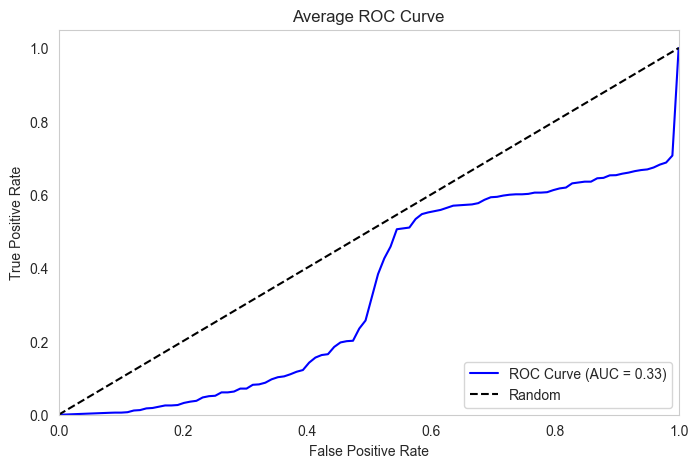

In [839]:
inf_model = ORCA(in_channels=X_train.shape[1], conv_out_channels=64, gat_heads=8)
inf_snapshot = SnapshotManager(inf_model)
inf_snapshot.load_latest()

predictions, probabilities, y_true = evaluate_model(inf_model, test_dataloader)

assert predictions.shape[0] == y_true.shape[0]

accuracy, precision, recall, f1, brier, roc_auc, hamming = calculate_metrics(predictions, probabilities, y_true)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Brier Score: {brier:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")
print(f"Hamming: {hamming:.4f}")

plot_roc_auc(probabilities, y_true)